In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("classic")
import operator
import functools
import itertools
import dataclasses
import json
import re
import collections
import pickle
import scipy.sparse as sp
from tqdm.autonotebook import tqdm

/home/remjo/.local/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
@dataclasses.dataclass
class ScriptParams():
    abstracts_p = "abstracts.txt"
    stop_words_p = "stopwords.txt"
    first_pass_p = "abstracts_p1.txt"
    second_pass_p = "abstracts_p2.txt"
    author_paper_p = "author_papers.txt"
    author_paper_pkl = "author_papers.pkl"
    author_index_pkl = "author_index.pkl"
    edgelist_p = "collaboration_network.edgelist.zip"
    adjacency_p = "adj.txt"
    authors_p = "authors.txt"

# Part 1: Preping data

## A: abstracts.txt

In [3]:
# I use a manually compiled list of stop words.
# Built by observing to most frequent words.
stopwords = set(map(str.strip, open(ScriptParams().stop_words_p).readlines()))
stem_re = re.compile("s$") #really simple stemming, just removing Ses.
def preprocess_wordlist(l):
    """ pre-processing pipeline for each abstract:
    - remove duplicates
    - lower the words.
    - remove stopwords.
    - applies a light stemming by removing the last "s" if present. (to equate plurals / verbs...)
    """
    remove_final_s = lambda w: w[:-1] if w[-1] == "s" else w
    return list(set(filter(lambda w: w not in stopwords, map(remove_final_s, map(str.lower, l)))))

In [4]:
def read_abstracts():
    """ read trought all abstracts. encode enverything to numpy array to be fast.
    returns:
    ------
    authors: array of all authors
    abstracts: array of all words index.
    offsets: array of offsets into indexes. indexes[offsets[i], offsets[i+1]] is the ith abstract.
    vocabulary: index to word mapping.
    frequencies: index to frequency mapping.
    """

    # use all words with more than 3 chars.
    # no digits.
    # only ascii. (non ascii words are too infrequent to provide usable information.)
    # case insensitive.
    word_plit_re = re.compile(r"\b[a-z]{3,}\b", flags = re.A | re.I)

    # use a counter to keep track of words frequencies.
    frequencies = collections.Counter()
    # use a defaultdict to map word -> index.
    vocabulary = collections.defaultdict(lambda: len(vocabulary))
    offsets = [0]
    authors = list()
    abstracts = list()
    
    with open(ScriptParams().abstracts_p) as f:
        for i, line in tqdm(enumerate(f)):
            author, json_str = line.split("----", 1)
            word = preprocess_wordlist(word_plit_re.findall(json_str))
            #g.write(str.join(" ", word)+"\n")
            frequencies.update(word)
            abstracts.append(np.fromiter((vocabulary[w] for w in set(word)), dtype=np.uint16, count=len(word)))
            authors.append(int(author))
            offsets.append(len(word))

    authors = np.asarray(authors, dtype=np.uint32)
    offsets = np.cumsum(np.asarray(offsets, dtype=np.uint32))
    vocabulary = np.asarray(list(vocabulary.keys())) # insertion order is preserved so the mapping is still valid.
    frequencies = np.asarray(list(frequencies.values())) # same.
    abstracts = np.concatenate(abstracts)
    out = (authors, abstracts, offsets, vocabulary, frequencies)

    np.savez(ScriptParams().first_pass_p, 
             authors=authors,
             abstracts=abstracts,
             offsets=offsets,
             vocabulary=vocabulary,
             frequencies=frequencies)
    return out

In [5]:
@dataclasses.dataclass
class TextData():
    """ a simple class to hold onto the data from the abstracts.
    """
    authors: np.ndarray
    abstracts: np.ndarray
    offsets: np.ndarray
    vocabulary: np.ndarray
    frequencies: np.ndarray

In [30]:
# load and save the data computed from abstracts.txt
# takes two minute and less than 1G of memory.
read_abstracts()

(array([      1957,       2468,       3603, ..., 2908511069, 2908517302,
        2908518491], dtype=uint32),
 array([   0,    1,    2, ..., 5782, 2622,   44], dtype=uint16),
 array([       0,       45,       63, ..., 57497892, 57497970, 57498017],
       dtype=uint64),
 array(['proprietary', 'developing', 'level', ..., 'imau', 'epgd',
        'dcrypp'], dtype='<U134'),
 array([ 27824,   2347, 133359, ...,      1,      1,      1]))

In [6]:
#load the previouly computed text data
with np.load(ScriptParams().first_pass_p+".npz", allow_pickle=True) as data:
    abstracts_data = TextData(**data)

In [7]:
def decode(i: int, data: TextData):
    """ returns the ith abstracts word array.
    """
    ab, of, vo = data.abstracts, data.offsets, data.vocabulary
    sentence = ab[of[i]:of[i+1]]
    return vo[sentence]

In [8]:
# check if we can decode correctly the ith abstract.
decode(1, abstracts_data)

array(['apparatuse', 'receiving', 'message', 'position', 'update',
       'switched', 'select', 'network', 'communication', 'terminal',
       'mobile', 'csfb', 'accesse', 'acces', 'circuit', 'support', 'cell',
       'fallback'], dtype='<U134')

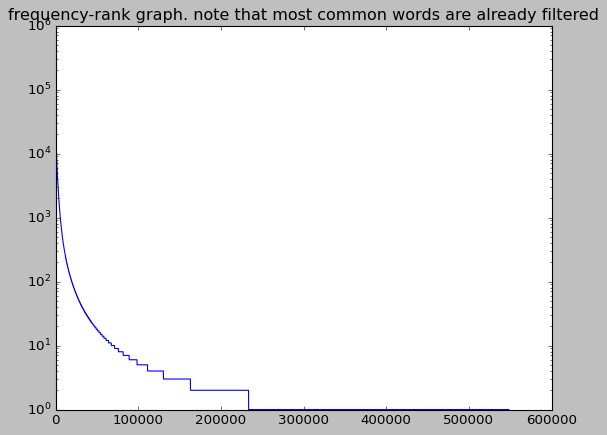

In [9]:
plt.semilogy(np.sort(abstracts_data.frequencies)[::-1]);
plt.title("frequency-rank graph. note that most common words are already filtered");

Since we have a lot of low frequency words, we will cut them off to oreduce the vocabulary size and improve future computations.

In [35]:
# getting a look a the most frequent words to build a custom blacklist
abstracts_data.vocabulary[np.argsort(abstracts_data.frequencies)[::-1][0:20]]

array(['model', 'compiled', 'application', 'information', 'network',
       'performance', 'user', 'algorithm', 'analysi', 'technique', 'set',
       'high', 'normal', 'executed', 'number', 'level', 'work', 'order',
       'proces', 'circuit'], dtype='<U134')

In [49]:
def cut_frequencies(data: TextData, cutoff=10):
    """ removes all words where frequencies are lesser or equal to cutoff.
    """
    ab, of, vo, fe = data.abstracts, data.offsets, data.vocabulary, data.frequencies
    
    # boolean masking.
    to_cut = fe<=cutoff
    print(f"cutting {to_cut.sum()} words.")
    
    # remove unecessary words.
    new_vo = vo[~to_cut]
    new_fe = fe[~to_cut]
    
    # mask over words that should be deleted
    ab_mask = to_cut[ab]
    # mapping to the new vocabulary indices
    new_voc_map = np.cumsum(~to_cut) - 1
    
    # remove unecessary words and map to new index.
    new_ab = new_voc_map[ab[~ab_mask]]
    
    # mapping to the new offests
    lens = np.cumsum(~ab_mask) - 1
    # first 0 offest is zero, ith is the number of valid word befor the previous offset
    # last is the lenght of the new abstracts.
    new_of = np.zeros_like(of)
    new_of[0:-1] = lens[of[0:-1]]
    new_data = TextData(vocabulary=new_vo,
                        frequencies=new_fe,
                        abstracts=new_ab,
                        offsets=new_of,
                        authors=data.authors)
    new_of[-1] = len(new_ab)
    
    
    
    np.savez(ScriptParams().second_pass_p, **dataclasses.asdict(new_data))
    return new_data

In [50]:
abstracts_data_2 = cut_frequencies(abstracts_data, 10)

cutting 481157 words.


In [65]:
# conserve RAM
del abstracts_data

NameError: name 'abstracts_data' is not defined

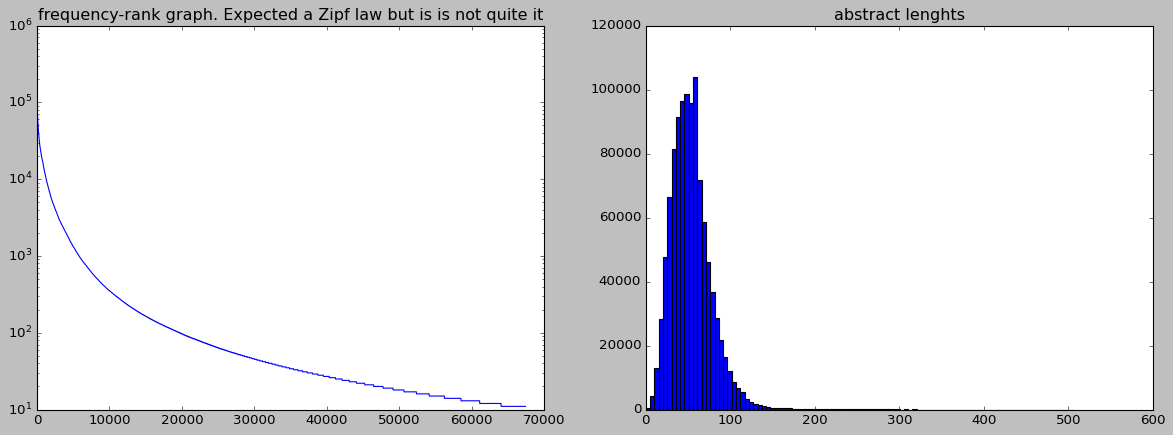

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.semilogy(np.sort(abstracts_data_2.frequencies)[::-1],);
ax1.set_title("frequency-rank graph.");
ax2.hist(np.diff(abstracts_data_2.offsets), bins=100);
ax2.set_title("abstract lenghts");

## B: author_papers.txt

In [4]:
def read_author_paper():
    """ load the author to papers mapping
    """
    number_split_re = re.compile(r"\d+")
    author_paper = dict()
    with open(ScriptParams().author_paper_p) as f:
        for line in f:
            numbers = list(map(int, number_split_re.findall(line)))
            author_paper[numbers[0]] = np.asarray(numbers[1:])
    with open(ScriptParams().author_paper_pkl, 'wb') as f:
        pickle.dump(author_paper, f)
    return author_paper

In [5]:
author_paper = read_author_paper()

In [183]:
# nota: there quite a few papers listed in author_papers
# that are not in abstracts.txt.
sum(map(len, author_paper.values())), len(abstracts_data_2.authors)

(1743871, 1056539)

##  C: collaborationnetwork.edgelist

In [5]:
@dataclasses.dataclass
class GraphData():
    """ a simple class to hold onto the data from the edgelist.
    """
    authors: np.ndarray
    A: np.ndarray

In [246]:
def read_edgelist():
    """ read the edge list.
    returns:
    -----
    A: adjacency matrix
    authors: index -> author mapping. It is the authors in sorted order.
    """
    print("reading edgelist..")
    edges = pd.read_csv(ScriptParams().edgelist_p,  sep=" ", header=None, dtype=np.uint32).to_numpy()
    
    print("building adjacency..")
    authors, E = np.unique(edges, return_inverse=True)
    # built the matrix symetric.
    E = E.reshape((-1, 2))
    filler = np.ones(2 * len(edges), dtype=np.bool)
    row = np.r_[E[:,0], E[:,1]]# A-> B edges
    col = np.r_[E[:,1], E[:,0]] # B -> A edges
    A = sp.csr_matrix((filler, (row, col)), shape=(len(authors), len(authors)))
    
    data = GraphData(authors=authors, A=A)
    sp.save_npz(ScriptParams().adjacency_p, A)
    np.savez(ScriptParams().authors_p, authors)
    
    author_index = dict(zip(authors, range(len(authors))))
    with open(ScriptParams().author_index_pkl, 'wb') as f:
        pickle.dump(author_paper, f)
        
    return A, authors,

In [247]:
read_edgelist();

reading edgelist..
building adjacency..


In [6]:
#load the previouly computed graph data
A = sp.load_npz(ScriptParams().adjacency_p + ".npz")
authors = np.load(ScriptParams().authors_p + ".npz")["arr_0"]
graph_data = GraphData(A=A, authors = authors)
with open(ScriptParams().author_index_pkl, "rb") as f:
    author_index = pickle.load(f)

In [251]:
# check: we do have all the authors in author_paper also in our graph.
# and both are sorted by the author value, making it easy to map between the two.
all(graph_data.authors == np.asarray(list(author_paper.keys())))

True